In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from yolox.exp import get_exp
from yolox.utils import fuse_model, get_model_info, postprocess, postprocess_object_pose, vis
from yolox.utils.object_pose_utils  import decode_rotation_translation
from yolox.utils.plots import plot_one_box, colors
from yolox.data.data_augment import ValTransform
from yolox.data.datasets import YCBV_CLASSES
import time
import copy
from loguru import logger

model_root_path = "models/small"
DEVICE = "cuda" if torch.cuda.is_available() else "mps"




#camera_matrix for test-split of ycbv dataset
ycbv_camera_matrix = np.array([[1066.778, 0, 312.9869],
                              [0.0, 1067.487, 241.3109],
                              [0.0, 0.0, 1.0]], dtype=np.float32)

_COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.286, 0.286, 0.286,
        0.429, 0.429, 0.429,
        0.571, 0.571, 0.571,
        0.714, 0.714, 0.714,
        0.857, 0.857, 0.857,
        0.000, 0.447, 0.741,
        0.314, 0.717, 0.741,
        0.50, 0.5, 0
    ]
).astype(np.float32).reshape(-1, 3)


#vertices for ycbv21 objects
ycbv_vertices = np.array([
    [51.1445, 51.223, 70.072],
    [35.865, 81.9885, 106.743],
    [24.772, 47.024, 88.0075],
    [33.927, 33.875, 51.0185],
    [48.575, 33.31, 95.704],
    [42.755, 42.807, 16.7555],
    [68.924, 64.3955, 19.414],
    [44.6775, 50.5545, 15.06],
    [51.0615, 30.161, 41.8185],
    [54.444, 89.206, 18.335],
    [74.4985, 72.3845, 121.32],
    [51.203, 33.856, 125.32],
    [80.722, 80.5565, 27.485],
    [58.483, 46.5375, 40.692],
    [92.1205, 93.717, 28.6585],
    [51.9755, 51.774, 102.945],
    [48.04, 100.772, 7.858],
    [10.5195, 60.4225, 9.4385],
    [59.978, 85.639, 19.575],
    [104.897, 82.18, 18.1665],
    [26.315, 38.921, 25.5655,]
    ], dtype=np.float32)

vertices_order = np.array([
            [-1, -1, -1],
            [-1, -1, 1],
            [-1, 1,  1],
            [-1, 1, -1],
            [1, -1, -1],
            [1, -1,  1],
            [1,  1,  1],
            [1,  1, -1],
            ], dtype=np.float32)

# camera_matrix for logitech c270 ->640x480
logitech_camera_matrix_resize = np.array([[1066.778, 0.0, 312.9869],
                                          [0.0, 1066.778, 241.3109],
                                          [0.0, 0.0, 1.0]], dtype=np.float32)

def project_3d_2d(pts_3d, rotation_mat, translation_vec, camera_matrix):
    xformed_3d = np.matmul(pts_3d, rotation_mat.T) + translation_vec
    xformed_3d[:,:3] = xformed_3d[:,:3]/xformed_3d[:,2:3]
    projected_2d = np.matmul(xformed_3d, camera_matrix.reshape((3, 3)).T)[:, :2]
    return projected_2d

def draw_bbox_2d(origin_img, dets, class_names, conf_thres=0.85):
    if len(dets.shape) > 2:
        dets = dets[0][0]

    for det in dets:
        box, score, cls = det[:4], det[4], int(det[5])
        print(box)
        if score>conf_thres:
            cls_id = int(cls)
            x0, y0 = int(box[0]), int(box[1])
            x1, y1 = int(box[2]), int(box[3])
            color = (_COLORS[cls] * 255).astype(np.uint8).tolist()
            cv2.rectangle(origin_img, (x0, y0), (x1, y1), color, 2)
                    #Labels on cuboid
            text = '{}:{:.1f}%'.format(class_names[cls], score * 100)
            txt_color = (0, 0, 0) if np.mean(_COLORS[cls]) > 0.5 else (255, 255, 255)
            font = cv2.FONT_HERSHEY_SIMPLEX
            txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
            txt_bk_color = (_COLORS[cls] * 255 * 0.7).astype(np.uint8).tolist()
            x0, y0 = int(box[0]), int(box[1])
            cv2.rectangle(
                origin_img,
                (x0, y0 + 1),
                (x0 + txt_size[0] + 1, y0 + int(1.5*txt_size[1])),
                txt_bk_color,
                -1
            )
            cv2.putText(origin_img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color, thickness=1)
    return origin_img

def draw_obj_pose(origin_img, dets, class_names, class_to_cuboid, camera_matrix, conf_thres=0.85):
    if len(dets.shape) > 2:
        dets = dets[0][0]

    for det in dets:
        box, score, cls = det[:4], det[4], int(det[5])
        if score>conf_thres:
            color = (_COLORS[cls] * 255).astype(np.uint8).tolist()
            r1, r2 = det[6:9, None], det[9:12, None]
            r3 = np.cross(r1, r2, axis=0)
            rotation_mat = np.concatenate((r1, r2, r3), axis=1)
            translation_vec = det[12:15]
            tx = translation_vec[0]
            ty = translation_vec[1]
            tz = translation_vec[2]
            x = camera_matrix[0,2] + camera_matrix[0,0] *tx/tz
            y = camera_matrix[1,2] + camera_matrix[1,1] *ty/tz
            X = (x - logitech_camera_matrix_resize[0,2])*tz/logitech_camera_matrix_resize[0,0]
            Y = (y - logitech_camera_matrix_resize[1,2])*tz/logitech_camera_matrix_resize[1,1]
            translation_vec[0] = X
            translation_vec[1] = Y
            cuboid_corners_2d = project_3d_2d(class_to_cuboid[int(cls)], rotation_mat, translation_vec, camera_matrix)
            draw_cuboid_2d(img=origin_img, cuboid_corners=cuboid_corners_2d, color=color)

            #Labels on cuboid
            text = '{}:{:.1f}%'.format(class_names[cls], score * 100)
            txt_color = (0, 0, 0) if np.mean(_COLORS[cls]) > 0.5 else (255, 255, 255)
            font = cv2.FONT_HERSHEY_SIMPLEX
            txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
            txt_bk_color = (_COLORS[cls] * 255 * 0.7).astype(np.uint8).tolist()
            x0, y0 = int(box[0]), int(box[1])
            cv2.rectangle(
                origin_img,
                (x0, y0 + 1),
                (x0 + txt_size[0] + 1, y0 + int(1.5*txt_size[1])),
                txt_bk_color,
                -1
            )
            cv2.putText(origin_img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color, thickness=1)
    return origin_img

def draw_cuboid_2d(img, cuboid_corners, color = (0, 255, 0), thickness = 2):
    box = np.copy(cuboid_corners).astype(np.int32)
    box = [tuple(kpt) for kpt in box]
    #front??? to check
    cv2.line(img, box[0], box[1], color, thickness)
    cv2.line(img, box[1], box[2], color, thickness)
    cv2.line(img, box[2], box[3], color, thickness)
    cv2.line(img, box[0], box[3], color, thickness)
    #back
    cv2.line(img, box[4], box[5], color, thickness)
    cv2.line(img, box[5], box[6], color, thickness)
    cv2.line(img, box[6], box[7], color, thickness)
    cv2.line(img, box[4], box[7], color, thickness)
    #sides
    cv2.line(img, box[0], box[4], color, thickness)
    cv2.line(img, box[1], box[5], color, thickness)
    cv2.line(img, box[2], box[6], color, thickness)
    cv2.line(img, box[3], box[7], color, thickness)
    return img

class Predictor(object):
    def __init__(
        self,
        model,
        exp,
        cls_names=YCBV_CLASSES,
        trt_file=None,
        decoder=None,
        device="cpu",
        fp16=False,
        legacy=False,
        task="2dod",
        data_set="coco"
    ):
        self.model = model
        self.cls_names = cls_names
        self.decoder = decoder
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.device = device
        self.fp16 = fp16
        self.preproc = ValTransform(legacy=legacy)
        self.task = task
        self.data_set = data_set
        self.cad_models = model.head.cad_models
        """if trt_file is not None:
            from torch2trt import TRTModule

            model_trt = TRTModule()
            model_trt.load_state_dict(torch.load(trt_file))

            x = torch.ones(1, 3, exp.test_size[0], exp.test_size[1]).cuda()
            self.model(x)
            self.model = model_trt """

    def inference(self, img):
        img_info = {"id": 0}
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
        img_info["ratio"] = ratio

        img, _ = self.preproc(img, None, self.test_size)
        img_info["img"] = img.transpose(1, 2, 0)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        if self.device == "gpu":
            img = img.cuda()
        else:
            img = img.to(self.device)

        if self.fp16:
            img = img.half()  # to FP16   

        with torch.no_grad():
            t0 = time.time()
            outputs = self.model(img)
            if self.decoder is not None:
                outputs = self.decoder(outputs, dtype=outputs.type())
            if self.task == "object_pose":
                outputs = postprocess_object_pose(
                    outputs, self.num_classes, self.confthre,
                    self.nmsthre, class_agnostic=True
                )
            else:
                print(outputs)
                outputs = postprocess(
                    outputs, self.num_classes, self.confthre,
                    self.nmsthre, class_agnostic=True
                )
            logger.info("Infer time: {:.4f}s".format(time.time() - t0))
        return outputs, img_info

    def visual(self, output, img_info, cls_conf=0.35):
        ratio = img_info["ratio"]
        img = img_info["raw_img"]
        if output is None:
            return img
        output = output.cpu()

        bboxes = output[:, 0:4]

        # preprocessing: resize
        bboxes /= ratio

        cls = output[:, 6]
        scores = output[:, 4] * output[:, 5]

        vis_res = vis(img, bboxes, scores, cls, cls_conf, self.cls_names)
        return vis_res

    def visual_object_pose(self, output, img_info, cls_conf):
        img = np.ascontiguousarray(img_info["img"])
        img_2d = copy.deepcopy(img)
        im_cuboid = copy.deepcopy(img)
        im_mask = copy.deepcopy(img)
        camera_matrix = self.cad_models.camera_matrix
        if output is None:
            return img
        output = output.cpu()
        if isinstance(camera_matrix, dict):
            camera_matrix = camera_matrix['camera_uw']
        for ind in range(output.shape[0]):
            pose = {}
            pose['xy'] = output[ind, 11:13]
            rotation_vec, translation_vec = decode_rotation_translation(output[ind], camera_matrix=camera_matrix)
            pose["rotation_vec"] = rotation_vec
            pose["translation_vec"] = translation_vec
            cls = output[ind][-1]
            color = colors(cls)
            plot_one_box(output[ind], img_2d, im_cuboid=im_cuboid, im_mask=im_mask, color=color, object_pose=True, label=str(int(cls.numpy())),
                  cad_models=self.cad_models, camera_matrix=camera_matrix, pose=pose, block_x=0, block_y=0, cls_names=self.cls_names, orig_shape=img.shape)
        return [img, img_2d, im_cuboid, im_mask]




exp = get_exp(exp_name="yolox-s-object-pose-ti-lite")
exp.num_classes = len(YCBV_CLASSES)
exp.nmsthre = 0.3
exp.test_conf = 0.3
model = exp.get_model()
weights = torch.load(os.path.join(model_root_path, 'best_ckpt.pth'), weights_only=True, map_location=DEVICE)
model.load_state_dict(weights['model'], strict=True)
#model.half()
model.eval()
model.to("cpu")
info = get_model_info(model, exp.test_size)
logger.info("Model Summary: {}".format(info))
model.to(DEVICE)
model.half()

predictor = Predictor(model, exp, cls_names=YCBV_CLASSES, device=DEVICE, task="object_pose", fp16=True)

imagePath = '/Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/YCB-V/train_real/000000/rgb/000001.png'
outputs, img_info = predictor.inference(imagePath)
vis_res = predictor.visual_object_pose(outputs[0], img_info, cls_conf=0)

#convert float to integers for plotting
vis_res = [np.array(img).astype(np.uint8) for img in vis_res]

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax[0].imshow(vis_res[0])
ax[0].set_title('Raw image')
ax[0].axis('off')
ax[1].imshow(vis_res[1])
ax[1].set_title('2D Bounding Box')
ax[1].axis('off')
ax[2].imshow(vis_res[2])
ax[2].set_title('Cuboid')
ax[2].axis('off')
ax[3].imshow(vis_res[3])
ax[3].set_title('Mask')
ax[3].axis('off')
plt.show()





In [ ]:
import onnxruntime as rt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

so = rt.SessionOptions()
providers = ['CPUExecutionProvider']
session = rt.InferenceSession(os.path.join(model_root_path,"yolox_s_object_pose_ti_lite.onnx"),providers=providers ,sess_options=so)


#Print input/ouput names and shapes
print("Input Name:", session.get_inputs()[0].name)
print("Input Shape:", session.get_inputs()[0].shape)
print("Input Type:", session.get_inputs()[0].type)
print("Output Name:", session.get_outputs()[0].name)
print("Output Shape:", session.get_outputs()[0].shape)
print("Output Type:", session.get_outputs()[0].type)

imagePath = '/Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/YCB-V/train_real/000000/rgb/000000.png'
input_size = (1, 3, 480, 640)

image = Image.open(imagePath).convert('RGB')
new_img_width = input_size[3]
new_img_height = float(new_img_width) / image.size[0] * image.size[1]
        
# Resize
img_resized = image.resize((int(new_img_width), int(new_img_height)), Image.LANCZOS)
crop_x = (img_resized.size[0] - input_size[3]) / 2
crop_y = (img_resized.size[1] - input_size[2]) / 2

crop_img = img_resized.crop((crop_x, crop_y, crop_x+input_size[3], crop_y+input_size[2]))
assert crop_img.size[0] == input_size[3] and crop_img.size[1] == input_size[2]

#HWC -> CHW
crop_img = np.array(crop_img).transpose(2, 0, 1)

img = crop_img.astype(np.float32)
ort_inputs = {session.get_inputs()[0].name: img[None, :, :, :]}
start = time.time()
output = session.run(None, ort_inputs)
end = time.time()
print("Inference time: ", end-start)

dets = output[0]
#image = np.array(image)
draw_img1 = draw_bbox_2d(np.array(image), dets, YCBV_CLASSES, 0.0)

draw_img2 = draw_obj_pose(np.array(image), dets, class_names=YCBV_CLASSES, class_to_cuboid=ycbv_vertices[:, None, :] * vertices_order, camera_matrix=ycbv_camera_matrix, conf_thres=0.0)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(draw_img1)
ax[0].set_title('Bounding Boxes')
ax[0].axis('off')
ax[1].imshow(draw_img2)
ax[1].set_title('Object Poses')
ax[1].axis('off')
plt.show()




In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

cx = 312.9869
cy = 241.3109
fx = 1066.778
fy = 1067.487
width = 640
height = 480
depth_scale = 0.1  # 若需要深度資訊，可另外保留此值

vertices = ycbv_vertices[:, None, :] * vertices_order

# 相機內參矩陣 (Camera Intrinsic Matrix)
camera_intrinsic = np.array([
    [fx,   0,  cx],
    [ 0,  fy,  cy],
    [ 0,   0,   1]
], dtype=float)

print("Updated camera intrinsic matrix:\n", camera_intrinsic)

def draw_2d_bbox(img, bbox, color=(0,255,0), thickness=2):
    print(bbox)
    x, y, w, h = bbox
    x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def draw_3d_box(img, corners_2d, color=(255,0,0), thickness=2):
    # corners_2d: shape=(2,8)
    corners_2d = corners_2d.T  # shape: (8,2)
    
    # 新增以下一行，確保座標是整數
    corners_2d = corners_2d.astype(int)

    # front face: 0,1,2,3; rear face:4,5,6,7
    front_face = [0,1,2,3,0]
    back_face = [4,5,6,7,4]
    for i in range(len(front_face)-1):
        cv2.line(img, tuple(corners_2d[front_face[i]]), tuple(corners_2d[front_face[i+1]]), color, thickness)
        cv2.line(img, tuple(corners_2d[back_face[i]]), tuple(corners_2d[back_face[i+1]]), color, thickness)
        cv2.line(img, tuple(corners_2d[front_face[i]]), tuple(corners_2d[back_face[i]]), color, thickness)
    return img

def project_to_image(pts_3d, R, T, camera_intrinsic):
    # pts_3d: shape=(3,N), R: 3x3, T: 3x1
    # 將模型座標下的點透過 R, T轉到攝影機坐標系下
    # 假設物件已定義在模型座標(0,0,0)為中心, R和T將model坐標轉到cam坐標
    # pts_cam = R * pts_3d + T
    #translat before rotation
    pts_cam = R @ pts_3d + T.reshape(3,1)
    # 投影到2D
    pts_2d = camera_intrinsic @ pts_cam
    pts_2d = pts_2d[:2,:] / pts_2d[2,:]
    return pts_2d

# 讀取COCO格式的註解檔 (請更新成實際檔名)
root_path = '/Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/YCB-V/train_real'
json_path = '/Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/YCB-V/annotations/instances_train_real.json'
with open(json_path, 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']

# 將annotation依image_id整理
ann_by_img = {}
for ann in annotations:
    img_id = ann['image_id']
    if img_id not in ann_by_img:
        ann_by_img[img_id] = []
    ann_by_img[img_id].append(ann)

# 選定一張圖來展示 (例如第一張)
target_img_info = images[0]
img_file = Path(target_img_info['image_folder'])/'rgb'/ target_img_info['file_name']
img_file = os.path.join(root_path, img_file)
print(f"Image file: {img_file}")
img = cv2.imread(str(img_file))
if img is None:
    print(f"Image not found: {img_file}")
    
img_2d = img.copy()
img_3d = img.copy()

if target_img_info['id'] in ann_by_img:
    for ann in ann_by_img[target_img_info['id']]:
        # 畫2D BBox
        category_id = ann['category_id']
        bbox = ann['bbox']
        draw_2d_bbox(img_2d, bbox, color=(0,255,0))

        # 取得R和T
        R_flat = ann['R'] # 9 elements
        R_matrix = np.array(R_flat).reshape(3,3)
        T_vec = np.array(ann['T']) # 3 elements

        # 將3D框投影到2D
        objject_vertices = vertices[category_id].T  # shape: (3,8)
        corners_2d = project_to_image(objject_vertices, R_matrix, T_vec, camera_intrinsic)
        draw_3d_box(img_3d, corners_2d, color=(255,0,0))

# 顯示兩張圖：左邊有2D BBox，右邊有3D投影框
img_2d_rgb = cv2.cvtColor(img_2d, cv2.COLOR_BGR2RGB)
img_3d_rgb = cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("2D Bounding Boxes")
plt.imshow(img_2d_rgb)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("3D Projection")
plt.imshow(img_3d_rgb)
plt.axis('off')

plt.show()

Image file: /Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/nuScenes/v1.0-mini/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg
[1206.5693751819115, 477.86111828160216, 19.31993062031279, 35.78389940122628]
[1547.0702570814112, 480.157008968664, 45.16844081344311, 62.39145766960684]
[1504.5998756594938, 489.2410313615559, 95.40012434050618, 34.402780206919715]
[1189.5640200302091, 479.5160042514046, 42.59497124178051, 36.90360306899066]
[1487.3940336599596, 478.23851454257533, 35.862981955800706, 62.75512032820859]
[680.7310301660298, 472.6859292687877, 18.536111826844035, 35.09120690002135]
[1188.1100058411344, 501.1718896539916, 62.28225969707819, 63.50526712146012]
[1165.1675845207922, 499.38661351787505, 58.161558824770054, 57.56755005205116]
[1002.677828993682, 473.88690882935975, 80.29531832916643, 65.01695071536119]
[1214.3796207477296, 480.52909275894405, 22.289487693053616, 36.6629119655957]
[62.56267031778199, 203.35161824878546, 559.734429514126

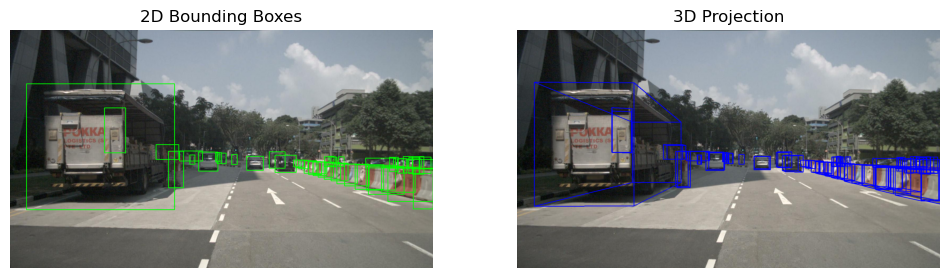

In [2]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import math

cx = 312.9869
cy = 241.3109
fx = 1066.778
fy = 1067.487
width = 640
height = 480
depth_scale = 0.1  # 若需要深度資訊，可另外保留此值


def draw_2d_bbox(img, bbox, color=(0,255,0), thickness=2):
    print(bbox)
    x, y, w, h = bbox
    x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def draw_3d_box(img, corners_2d, color=(255,0,0), thickness=2):
    # corners_2d: shape=(2,8)
    corners_2d = corners_2d.T  # shape: (8,2)
    
    # 新增以下一行，確保座標是整數
    corners_2d = corners_2d.astype(int)

    # front face: 0,1,2,3; rear face:4,5,6,7
    front_face = [0,1,2,3,0]
    back_face = [4,5,6,7,4]
    for i in range(len(front_face)-1):
        cv2.line(img, tuple(corners_2d[front_face[i]]), tuple(corners_2d[front_face[i+1]]), color, thickness)
        cv2.line(img, tuple(corners_2d[back_face[i]]), tuple(corners_2d[back_face[i+1]]), color, thickness)
        cv2.line(img, tuple(corners_2d[front_face[i]]), tuple(corners_2d[back_face[i]]), color, thickness)
    return img

def project_to_image(pts_3d, R, T, camera_intrinsic):
    # pts_3d: shape=(3,N), R: 3x3, T: 3x1
    # 將模型座標下的點透過 R, T轉到攝影機坐標系下
    # 假設物件已定義在模型座標(0,0,0)為中心, R和T將model坐標轉到cam坐標
    # pts_cam = R * pts_3d + T
    #translat before rotation
    pts_cam = R @ pts_3d + T.reshape(3,1)
    # 投影到2D
    pts_2d = camera_intrinsic @ pts_cam
    pts_2d = pts_2d[:2,:] / pts_2d[2,:]
    return pts_2d

def get_camera_matrix(calib):
    """
    從 calib (3×4) 中擷取相機內參 (3×3)。
    calib 一般形如：
    [
      [fx,  0, cx, Tx],
      [ 0, fy, cy, Ty],
      [ 0,  0,  1,  0]
    ]
    回傳 camera_matrix (3×3)。
    """
    # 將 calib 轉為 numpy array，方便切片
    calib_array = np.array(calib)
    # 取前 3 個欄位，即為 camera intrinsic matrix
    camera_matrix = calib_array[:, :3]
    return camera_matrix

def rotation_y_to_matrix(rotation_y_rad):
    """
    給定繞 y 軸的旋轉角(弧度)，回傳 3x3 旋轉矩陣 (numpy array)。
    """
    c = math.cos(rotation_y_rad)
    s = math.sin(rotation_y_rad)
    R = np.array([
        [ c,  0,  s],
        [ 0,  1,  0],
        [-s,  0,  c]
    ], dtype=np.float32)
    return R

def get_3d_box_corners_from_dim(dim):
    """
    根據 dim = [height, width, length]
    回傳 shape = (3, 8) 的 3D bounding box 8 個頂點坐標 (x, y, z)，
    物件中心位於 (0, 0, 0)。
    """
    h, w, l = dim[0]*1000, dim[1]*1000, dim[2]*1000
    
    # 以物件中心 (0,0,0) 為原點
    # x軸方向: ±(l/2), y軸方向: ±(h/2), z軸方向: ±(w/2)
    # （您可依照實際定義更改：像是把 y=0 設在底部）
    # x軸: ±l/2, y軸: [0 ~ -h], z軸: ±w/2
    x_corners = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2]
    y_corners = [ 0,     0,     0,     0,  -h,   -h,   -h,   -h ]
    z_corners = [ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2]
    
    # 組合為 (3, 8) 的 numpy array: [[x1..x8],[y1..y8],[z1..z8]]
    corners_3d = np.vstack((x_corners, y_corners, z_corners))
    return corners_3d

# 讀取COCO格式的註解檔 (請更新成實際檔名)
root_path = '/Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/nuScenes/v1.0-mini'
json_path = '/Users/jon/NTNU Dropbox/WiseSync/NAS/Datasets/nuScenes/annotations_6sweeps/mini_train.json'
with open(json_path, 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']

# 將annotation依image_id整理
ann_by_img = {}
for ann in annotations:
    img_id = ann['image_id']
    if img_id not in ann_by_img:
        ann_by_img[img_id] = []
    ann_by_img[img_id].append(ann)

# 選定一張圖來展示 (例如第一張)
target_img_info = images[0]
img_file = target_img_info['file_name']
img_file = os.path.join(root_path, img_file)
print(f"Image file: {img_file}")
img = cv2.imread(str(img_file))
if img is None:
    print(f"Image not found: {img_file}")
    
img_2d = img.copy()
img_3d = img.copy()

if target_img_info['id'] in ann_by_img:
    for ann in ann_by_img[target_img_info['id']]:
        # 畫2D BBox
        category_id = ann['category_id']
        bbox = ann['bbox']
        draw_2d_bbox(img_2d, bbox, color=(0,255,0))

        # 取得R和T
        R_flat = ann['R'] # 9 elements
        R_matrix = np.array(R_flat).reshape(3,3)
        T_vec = np.array(ann['T']) # 3 elements

        # 將3D框投影到2D
        objject_vertices = get_3d_box_corners_from_dim(ann['dim'])
        camera_intrinsic = get_camera_matrix(target_img_info['calib'])
        corners_2d = project_to_image(objject_vertices, R_matrix, T_vec, camera_intrinsic)
        draw_3d_box(img_3d, corners_2d, color=(255,0,0))

# 顯示兩張圖：左邊有2D BBox，右邊有3D投影框
img_2d_rgb = cv2.cvtColor(img_2d, cv2.COLOR_BGR2RGB)
img_3d_rgb = cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("2D Bounding Boxes")
plt.imshow(img_2d_rgb)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("3D Projection")
plt.imshow(img_3d_rgb)
plt.axis('off')

plt.show()